# Extragere segmentari pentru paper

In [1]:
from torch.utils.data import Dataset
import torchvision.transforms.functional as F
import torch
import os

%matplotlib widget

from utils.function_lib import *
from utils.LiverDataset import *
from utils.DiceLoss import *

from ModelBuilder.ResNet152_DeepLab import ResNet152DeepLab
from ModelBuilder.ResNeXt101_DeepLab import ResNeXt101DeepLab
from ModelBuilder.DenseNet201_DeepLab import DenseNet201DeepLab
from ModelBuilder.InceptionV3_DeepLab import InceptionV3DeepLab
from ModelBuilder.ConvNeXt_DeepLab import ConvNeXtDeepLab
from ModelBuilder.ClassifierHead import DeepLabHead

In [2]:
transform_image = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize(256, interpolation=transforms.functional.InterpolationMode.BILINEAR, antialias=True),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.2], std=[0.2])
    ])
transform_mask = transforms.Compose(
    [
        transforms.ToTensor()
    ])

path = 'G:/MachineLearning/liver-database/'

dataset_test = LiverDataset(path + 'validation/', transform_image=transform_image, transform_mask=transform_mask)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=True, num_workers=8, pin_memory=True)

## Functia de afisare

In [3]:
def show_segmentation(output_predictions, mask, input_tensor):
    palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = torch.as_tensor([i for i in range(3)])[:, None] * 1.1 * palette
    colors = (colors % 255).numpy().astype("uint8")

    # plot the semantic segmentation predictions of 21 classes in each color
    r = Image.fromarray(output_predictions.byte().cpu().numpy())
    r.putpalette(colors)

    r_mask = Image.fromarray(mask.byte().cpu().numpy())
    r_mask.putpalette(colors)
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(r)
    plt.subplot(1, 3, 2)
    plt.imshow(r_mask)
    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(input_tensor.numpy()))
    plt.show()

## Functia de segmentare a imaginii

In [4]:
def eval_model(dataset, idx, model, device):
    model.eval()
    input_tensor, mask = dataset.__getitem__(idx)
    input_batch = input_tensor.repeat(2, 1, 1, 1)
    pred = model(input_batch.to(device))

    final_func = nn.Sigmoid()
    pred = final_func(pred).squeeze()
    pred = torch.nn.functional.interpolate(pred.unsqueeze(0), size=512, mode="bilinear", align_corners=False).squeeze()
    output_predictions = torch.round(pred[0])
    output_predictions = output_predictions.detach().squeeze()
    mask = mask.cpu().squeeze()
    return input_tensor, mask, output_predictions

## Incarcam modelul

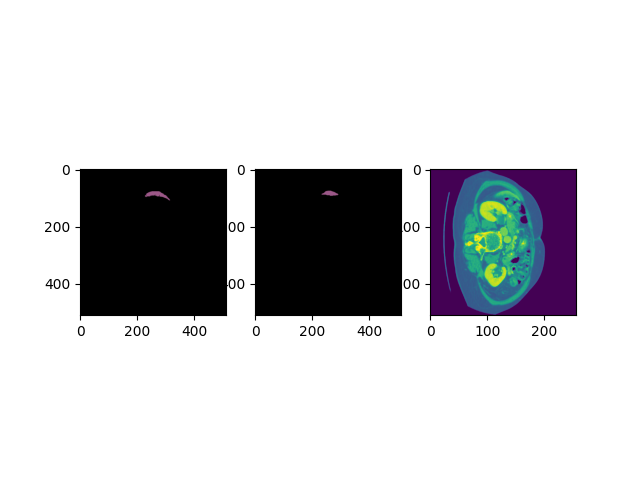

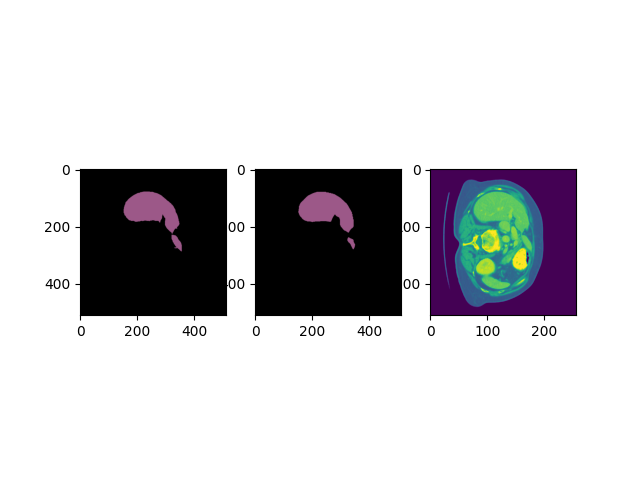

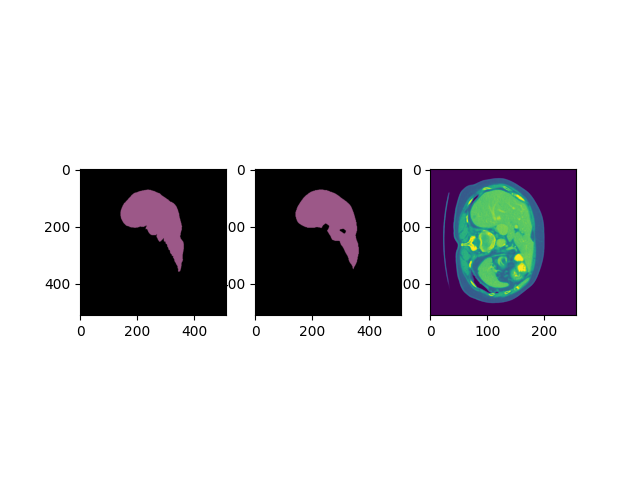

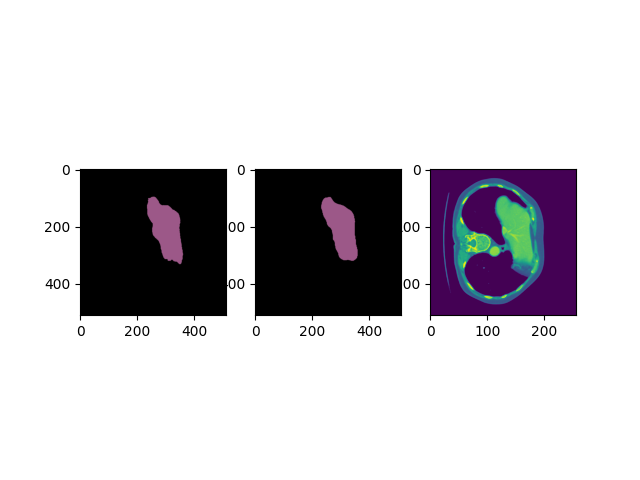

In [5]:
model_name = 'ResNeXt101'
model_path = 'G:/MachineLearning/models/' + model_name + '/' + model_name + '_checkpoint.pt'
if model_name == 'ResNet152':
    model = ResNet152DeepLab()
elif model_name == 'ResNeXt101':
    model = ResNeXt101DeepLab()
elif model_name == 'DenseNet201':
    model = DenseNet201DeepLab()
elif model_name == 'Inception':
    model = InceptionV3DeepLab()



checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])
device = torch.device('cpu')
model = model.to(device)

for idx in [45, 55, 60, 70]:
    input, output, ground_truth = eval_model(dataset_test, idx, model, device)
    show_segmentation(output, ground_truth, input)